# Harmonic Oscillator State Preparation

We aim to prepare the 9th state $\ket{9}$ of a @quantum-harmonic-oscillator, defined by the @hamiltonian $H = \frac{P^2}{2m} + \frac{1}{2}m \omega^2 X^2$, by starting at the ground state $\ket{0}$, and evolving both the centre $c$ and angular frequency $\omega$ of the system until we arrive at the desired target state. In order to both reduce numerical stability problems and dimension issues, we work in dimensionless unites. This means that we rewrite the resulting @hamiltonian, $H = ( - \frac{1}{2m} \frac{\partial^2}{\partial x^2} + m \omega^2 x^2)$ using $\tilde{x} = x \left ( {\frac{\hbar}{m \omega}} \right )^{- \frac{1}{2}} \Leftrightarrow x = \tilde{x} \left ( {\frac{\hbar}{m \omega}} \right )^{\frac{1}{2}}$, giving us the resulting equation $H = \frac{1}{2} \hbar \omega ( - \frac{\partial^2}{\partial \tilde{x}^2} + \tilde{x}^2)$. The resulting equation is easier to analyse with units of $\frac{1}{2} \hbar \omega$, where the expected energy levels are the odd integers ( These would be half integers if we used units of $\hbar \omega$.

# Setup

We start with our @usual-imports .

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import torch

plt.figure(figsize=(20,3))


<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

We ensure pytorch makes use of the GPU for efficiency

In [2]:
# https://github.com/pytorch/tutorials/issues/3263#issue-2811049983
device_name = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")
    # device_name = torch.cpu ... # TODO: Find the cpu device name

torch.set_default_device(device)
print(f"Using {device} device: {device_name}")

Using cuda device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


With the above set, we will use the @finite-differences-method to modelling the evolution of our quantum system. We work in @dimentionless-units in order to increase the numerical stability of our system. The main variables used are explained in code.

In [3]:
n_time_intervals:int = 20 # How many time steps we will consider in our time evolution
number_of_energy_levels:int = 20 # Used to ensure the numerical stability of our system
omega:float = 10. # The angular frequency we will be working with. Due to dimensionless unites, this becomes irrelevant :(
resolution:int = 191 # The spatial resolution of our system. primes if needed: 191, 1039, 11279
target_energy_level:int = 9
time_delta:float = 1. # The average time spent on each time evolution
total_evolution_time:float = time_delta * n_time_intervals
L : float = 10 # The width of our system
x_max:float = L # Upper limit of our space
x_min:float = -1 * L # Lower limit of our space

We build a vector `valid_x`, used to represent space in our system

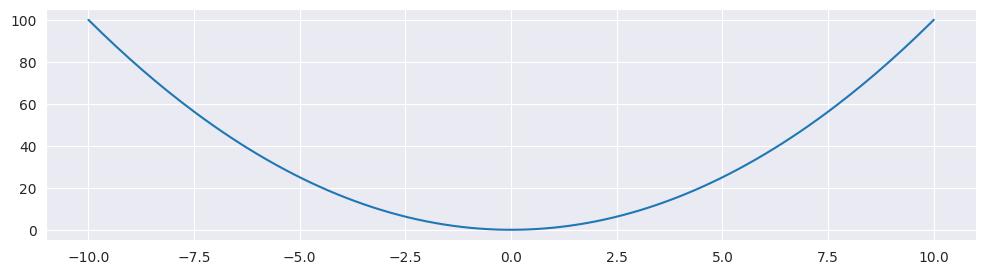

In [4]:
valid_x = torch.linspace(x_min, x_max, resolution)
delta_x = valid_x[1] - valid_x[0]

def potential(x):
    return x**2

plt.figure(figsize=(12,3))
plt.plot(valid_x.cpu(), potential(valid_x.cpu()))

The associated @hamiltonian has the usual form $H(x) = \frac{P^2}{2m} + V(x)$, which after unit inclusions becomes $H = \frac{1}{2} \hbar \omega ( - \frac{\partial^2}{\partial \tilde{x}^2} + \tilde{x}^2)$. The momentum component is built using @finite-differences-method, and the potential is represented as a @diagonal-matrix, resulting in a @tridiagonal-matrix.

In [5]:
# We keep a "omega_multiplier" factor to factor in the evolution of our system under a different angular frequency omega than the one used for scaling. This is essential for our time step evolution
def generate_hamiltonian(omega_multiplier: torch.Tensor | float = torch.tensor(1), center: torch.Tensor | float=torch.tensor(0)) -> torch.Tensor:

    # Using dimensionless units
    return 2 * torch.diag(torch.ones(resolution)) / delta_x**2 \
- (( torch.diag(torch.ones(resolution - 1), diagonal=1) + torch.diag(torch.ones(resolution - 1), diagonal=-1)) / delta_x**2) \
+ torch.diag(torch.tensor([(omega_multiplier*x)**2 for x in valid_x]))

    # Using dimensionless units with a scaling to reduce numerical instability due to delta_x
#     return 2 * torch.diag(torch.ones(resolution)) / delta_x**2 \
# - (( torch.diag(torch.ones(resolution - 1), diagonal=1) + torch.diag(torch.ones(resolution - 1), diagonal=-1)) / delta_x**2) \
# + torch.diag(torch.tensor([(omega_multiplier*x)**2 for x in valid_x]))

hamiltonian = generate_hamiltonian(omega_multiplier=1)

To ensure the correctness of the setup, we calculate and display the lowest energy levels as separate plots.

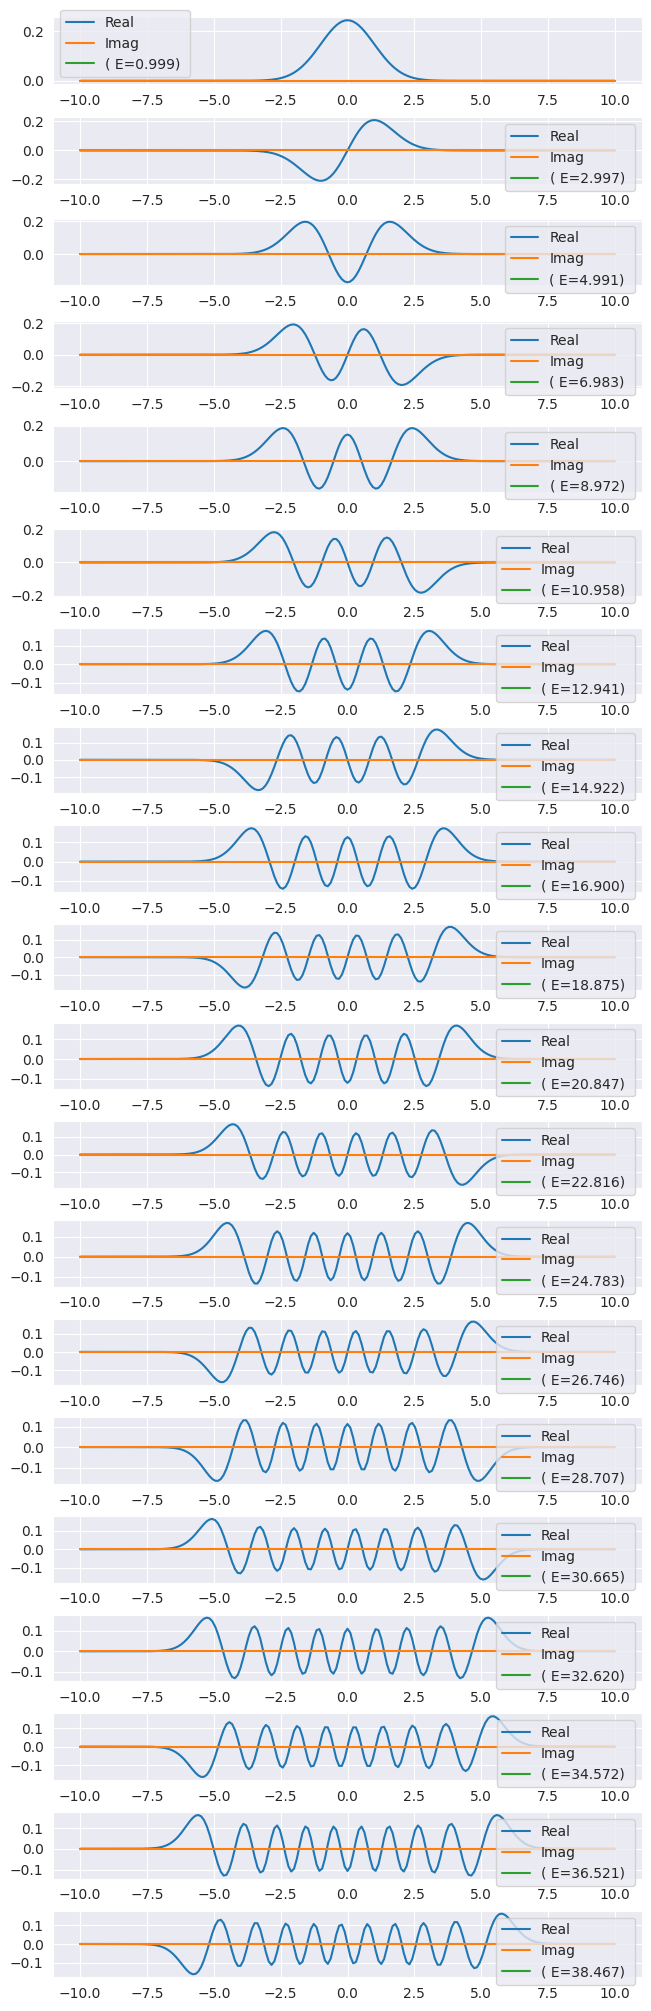

In [6]:
eigenvalues, eigenvectors = torch.linalg.eigh(hamiltonian)
eigenvalues = eigenvalues[:number_of_energy_levels]
eigenvectors = torch.transpose(eigenvectors, dim0=0, dim1=1)[:number_of_energy_levels]

fig, axes = plt.subplots(number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(number_of_energy_levels)
for i, (val, vector) in enumerate(zip(eigenvalues, eigenvectors)):
    axes[i].plot(valid_x.cpu().numpy(), np.real(vector.cpu().numpy()), label=f"Real")
    axes[i].plot(valid_x.cpu().numpy(), np.imag(vector.cpu().numpy()), label=f"Imag")
    axes[i].plot([],[], label=f"( E={np.real(val):.3f}) ")
    axes[i].legend(loc='best')

plt.show()

These energy levels theoretically should be @orthogonal. In practice we have rounding errors due to numerical unstability. We can see observe below that our error is capped at $10^{-6}$.

<Axes: >

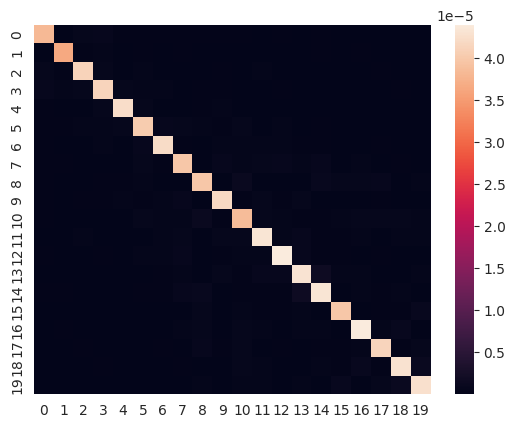

In [7]:
# Ideally this should all be zeroes
error_matrix = torch.abs(eigenvectors @ torch.transpose(eigenvectors, dim0=0, dim1=1)) - torch.eye(number_of_energy_levels)
sns.heatmap(np.abs(error_matrix.cpu().numpy()))

Below we ensure that our initial and target states have the desired form

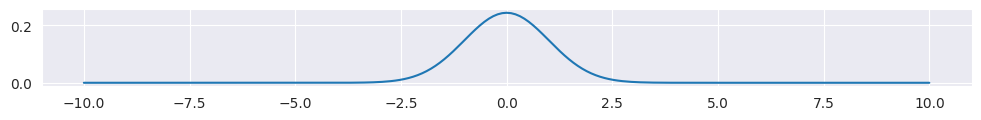

In [8]:
origin_state = eigenvectors[0, :].clone().type(torch.complex64)
plt.figure(figsize=(12,1))
plt.plot(valid_x.cpu(), np.real(origin_state.cpu().clone().detach()))

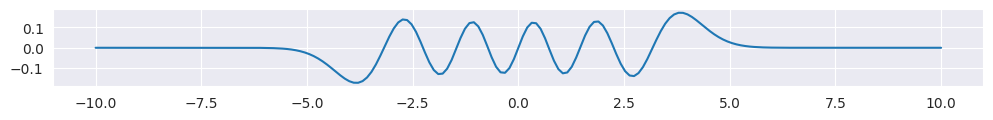

In [9]:
target_state = eigenvectors[target_energy_level, :].clone().type(torch.complex64)
plt.figure(figsize=(12,1))
plt.plot(valid_x.cpu(), np.real(target_state.cpu().clone().detach()))

We use @fidelity as our loss function

In [10]:
def fidelity(state_a: torch.Tensor, state_b: torch.Tensor) -> torch.Tensor:
    return torch.div(
        torch.abs(torch.tensordot(state_a, state_b, dims=1)),
        torch.mul(
            torch.norm(state_a, p=2),
            torch.norm(state_b, p=2)
        )
    )**2

# Quantum Evolution Neural Network Layer

To ensure that @backpropagation works, we need to build our quantum evolution as pytorch tensors, allowing us to get automatic back propagation. For each time interval we control our parameters are $\omega$, $c$ and $t$, used in our @potential $V(x) = \omega^2 (x-c)^2$ which is a pplied for a time duration of $t$.

In [11]:
x_squared = torch.tensor([x**2 for x in valid_x])
x_linear = torch.tensor([x for x in valid_x])

class HarmonicEvolutionLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.omega = torch.nn.Parameter(1.2 * torch.rand(()), requires_grad=True) # Include a \times omega factor if not working in dimensionless units
        self.center = torch.nn.Parameter((torch.rand(()) - .5) * x_max, requires_grad=True)
        self.time = torch.nn.Parameter(time_delta * torch.rand(()), requires_grad=True)
        self.linear_x = x_linear.detach().clone()
        self.squared_x = x_squared.detach().clone()

    def forward(self, x): # x is our quantum state
        momentum_component = torch.subtract(
            torch.multiply(
                torch.Tensor(2 / delta_x**2),
                torch.diag(torch.ones(resolution))
            ),
            torch.divide(
                torch.add(
                    torch.diag(torch.ones(resolution - 1), diagonal=1),
                    torch.diag(torch.ones(resolution - 1), diagonal=-1)
                ),
                torch.Tensor(delta_x **2)
            )
        )
        potential_component = torch.diag(
            torch.multiply(
                torch.multiply(self.omega**2, -1),
                torch.subtract(
                    .5 * torch.add(self.squared_x, self.center**2),
                    self.center * self.linear_x
                )
            )
        ) # - .5 ( omega^2 (x-c)^2 ) = omega^2 ( x^2 + c^2 - .5xc )

        layer_hamiltonian = torch.add(momentum_component, potential_component)
        unitary = torch.linalg.matrix_exp(-1j * self.time * layer_hamiltonian)
        y = torch.matmul(unitary, x) # TODO: Use torch.nn.LayerNorm instead
        return torch.div(y, torch.norm(y, p=2))
        # return self.omega ** 2 * (x - self.center)**2

    def string(self):
        return f"e^(iH*{self.time:.3f}), V(x) = .5 * ( {self.omega:.2f}^2 (x - {self.center:.2f})^2)"

Our process requires the use of time steps with distinct $\omega$ and $c$ values in order to simulate our system.

In [12]:
model = torch.nn.Sequential()
model.cuda()
for i in range(n_time_intervals):
    model.add_module(f"H{i}", HarmonicEvolutionLayer())

In [13]:
# See PyTorch plan. This is commented out as the generated image is too big to render nicely.
# from torchviz import make_dot
# make_dot(
#     model(origin_state),
#     params=dict(model.named_parameters()),
#     # show_attrs=True,
#     # show_saved=True
# )

We need to design the @loss-function we want to maximise. This includes the @fidelity defined above, but also other desired properties of our process, such as the requirement for positive $\omega$ and $t$ values, the usage of $t$ values that lead to the desired total time, and the reduction of an imaginary component chosen to minimize th momentum of the reached state.

In [14]:
def loss_function(
        internal_evolved_state: torch.Tensor,
        # internal_omega_list: torch.Tensor,
        # internal_time_list: torch.Tensor,
        internal_target_state: torch.Tensor
) -> torch.Tensor:
    fidelity_loss = torch.subtract(
            fidelity(internal_evolved_state, internal_target_state),
            1
        )**2

    imaginary_component = torch.mul(
        torch.subtract(
            2 * torch.norm(torch.imag(internal_evolved_state), p=2),
            1
        )**2,
        1e-1
    )

    normalization_error = 1e-1 * torch.square(torch.subtract(
        torch.norm(internal_evolved_state, p=2),
        torch.tensor(1)
    ))

    return torch.add(
        torch.add(
            fidelity_loss,
            imaginary_component
        ),
        normalization_error
    )

# TODO: Have this as a regularizer
# We want to regularize the total time
# We want to regularize the omegas/etc in each layer
# time_loss = 10**-4 * torch.math.divide(torch.math.reduce_sum(internal_time_list) - total_evolution_time, total_evolution_time)**2
#
# negative_time_loss = -1 * 10**3 * np.min([np.min(internal_time_list), 0])
# negative_omega_loss = -1 * 10**3 * np.min([np.min(internal_omega_list), 0])
# large_omega_loss = 10**-4 * np.max(internal_omega_list)**2

We use the @Adam-optimizer as our learning methodology

In [15]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3, #TODO: Optimize the learning rate https://discuss.pytorch.org/t/get-the-best-learning-rate-automatically/58269/4
    # fused=True
    # betas=(0.9, 0.999),
    # dampening=1,
    # weight_decay=1e-12
)

The optimization process applies @backpropagation of the loss calculated through simulation of the quantum evolution, as traditionally done in @reinforcement-learning.

In [16]:
for t in range(4100):

    evolved_state = model(origin_state)
    loss = loss_function(internal_evolved_state=evolved_state, internal_target_state=target_state)

    # if t % 50 == 0:
    if t & (t-1) == 0: # Prints fidelity when the training loop is a power of 2 # https://stackoverflow.com/a/57025941
        phi_imag:float = torch.norm(torch.imag(evolved_state), p=2) ** 2
        phi_real:float = torch.norm(torch.real(evolved_state), p=2) ** 2
        print(f"{t}: Fid:{100*fidelity(target_state, evolved_state):.2f}% (Im:{100 * phi_imag:.2f}%, Re:{100*phi_real:.2f}%)")
        # + "<" + "|".join([f"{param.data:.1f}" for name, param in model.named_parameters()]) + ">")
        # I do not need to know the parameter values during training

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0: Fid:3.68% (Im:40.95%, Re:59.05%)
1: Fid:4.40% (Im:40.62%, Re:59.38%)
2: Fid:5.19% (Im:39.52%, Re:60.48%)
4: Fid:7.02% (Im:37.29%, Re:62.71%)
8: Fid:10.10% (Im:36.22%, Re:63.78%)
16: Fid:12.81% (Im:40.01%, Re:59.99%)
32: Fid:19.51% (Im:46.38%, Re:53.62%)
64: Fid:33.17% (Im:37.08%, Re:62.92%)
128: Fid:40.05% (Im:25.89%, Re:74.11%)
256: Fid:47.08% (Im:29.14%, Re:70.86%)
512: Fid:50.51% (Im:27.65%, Re:72.35%)
1024: Fid:54.59% (Im:27.24%, Re:72.76%)


KeyboardInterrupt: 

By comparing the obtained state and the target state, we can get a visual feel for how far our solution is from the desired $\ket{9}$ state.

In [ ]:
target_state = eigenvectors[target_energy_level, :].clone().type(torch.complex64)
plt.figure(figsize=(12,3))
plt.plot(valid_x.cpu(), np.real(origin_state.cpu().clone().detach()), label=f"Ground state")
plt.plot(valid_x.cpu(), np.real(target_state.cpu().clone().detach()), label=f"Target state")
plt.plot(valid_x.cpu(), np.real(model(origin_state).cpu().clone().detach()), label=f"Evolved state ( Real )")
plt.plot(valid_x.cpu(), np.imag(model(origin_state).cpu().clone().detach()), label=f"Evolved state ( Imag )")
plt.legend(loc='best')

plt.show()

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 1, layout='constrained')
fig.set_figheight(2)
axes[0].plot(
    valid_x.cpu().numpy(),
    np.real(target_state.cpu().clone().detach()),
    label="Target State Real"
)
axes[0].plot(
    valid_x.cpu().numpy(),
    np.imag(target_state.cpu().clone().detach()),
    label="Target State Imag"
)
axes[0].legend(loc='best')
axes[1].plot(
    valid_x.cpu().numpy(),
    np.real(model(origin_state).cpu().clone().detach()),
    label=f"Evolved State Real"
)
axes[1].plot(
    valid_x.cpu().numpy(),
    np.imag(model(origin_state).cpu().clone().detach()),
    label=f"Evolved State Imag"
)
axes[1].legend(loc='best')

plt.show()


We also extract the optimal parameters

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.data:.3f}", end=" | ")

In [ ]:
# Extract the obtained values
final_omega_list = []
final_center_list = []
final_time_list = []
for i, layer in enumerate(model):
    omega, center, time = (
        list(model[i].parameters())[0].data.cpu().numpy(),
        list(model[i].parameters())[1].data.cpu().numpy(),
        list(model[i].parameters())[2].data.cpu().numpy()
    )
    final_omega_list.append(omega)
    final_center_list.append(center)
    final_time_list.append(time)

# (TODO) Clear the steps below

In [ ]:
def np_generate_hamiltonian(np_omega: float, np_center: float, np_valid_x: np.array) -> np.array:

    # P^2 term
    temp_hamiltonian = scipy.sparse.eye(resolution, resolution, format='lil') * 2
    for i in range(resolution - 1):
        temp_hamiltonian[i, i + 1] = -1
        temp_hamiltonian[i + 1, i] = -1

    # # Turns the space cyclic. Useful for modelling ring interferometry
    # inner_hamiltonian[0, resolution - 1] = -1
    # inner_hamiltonian[resolution - 1, 0] = -1

    np_delta_x = np_valid_x[1] - np_valid_x[0]
    temp_hamiltonian = np.divide(temp_hamiltonian, np_delta_x ** 2)

    # V(X) term
    for i in range(resolution):
        temp_hamiltonian[i, i] += 1/2 * np_omega**2 * (np_valid_x[i] - np_center)**2

    return temp_hamiltonian.tocsc()

In [ ]:
def plot_waves(
    omega_list: np.array,
    center_list: np.array,
    time_list: np.array,
    show_fidelity:bool = True
) -> None:

    assert len(omega_list) == len(time_list), f"The length of omega_list does not match the length of time_list: {len(omega_list)}!={len(time_list)}"

    np_valid_x = valid_x.cpu().numpy()
    np_evolved_state = deepcopy(origin_state.cpu().numpy())
    np_target_state = deepcopy(target_state.cpu().numpy())
    fig, axes = plt.subplots(n_time_intervals + 1, 1, layout='constrained')
    fig.set_figheight(n_time_intervals * 2)
    axes[0].plot(np_valid_x, np.real(np_evolved_state), label="Real")
    axes[0].plot(np_valid_x, np.imag(np_evolved_state), label="Imag")
    np_fidelity = np.abs(np.dot(np_evolved_state, np_target_state))**2
    if show_fidelity:
        axes[0].plot([], [], label=f"$\\mathcal{{F}}={100*np_fidelity:.2f}$")
    axes[0].legend(loc="best")

    for i, (temp_omega, temp_center, temp_time) in enumerate(zip(omega_list, center_list, time_list)):
        temp_hamiltonian = np_generate_hamiltonian(
            np_omega=temp_omega,
            np_center=temp_center,
            np_valid_x=np_valid_x,
        )
        unitary = scipy.sparse.linalg.expm(-1j * temp_hamiltonian * temp_time)
        np_evolved_state = unitary * np_evolved_state
        axes[i+1].plot(np_valid_x, np.real(np_evolved_state), label="Real")
        axes[i+1].plot(np_valid_x, np.imag(np_evolved_state), label="Imag")
        axes[i+1].plot(np_valid_x, np.real(np_target_state), label="target")
        if show_fidelity:
            np_fidelity = np.abs(np.dot(np_evolved_state, np_target_state))**2

            axes[i+1].plot([], [], label=f"$\\mathcal{{F}}={100*np_fidelity:.2f}\\%$")
            axes[i+1].plot([] , [], label=f"$\\omega={temp_omega:.2f}$")
            axes[i+1].plot([] , [], label=f"$t={temp_time:.2f}$")
        axes[i+1].legend(loc="best")

## omega

In [ ]:
plt.figure(figsize=(8,1))
plt.step(
    np.concatenate((np.array([0]), np.cumsum(final_time_list))),
    np.concatenate((final_omega_list, np.array([final_omega_list[-1]]))),
    label="$\\omega$"
)
plt.legend(loc="best")

## center

In [ ]:
plt.figure(figsize=(8,1))
plt.step(
    np.concatenate((np.array([0]), np.cumsum(final_time_list))),
    np.concatenate((final_center_list, np.array([final_center_list[-1]]))),
    label="center"
)
plt.legend(loc="best")


## state

In [ ]:
plot_waves(final_omega_list, final_center_list, final_time_list)